In [46]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, quantile_transform

import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install koreanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 38.1 MB/s eta 0:00:00


In [3]:
import koreanize_matplotlib

# 신버전

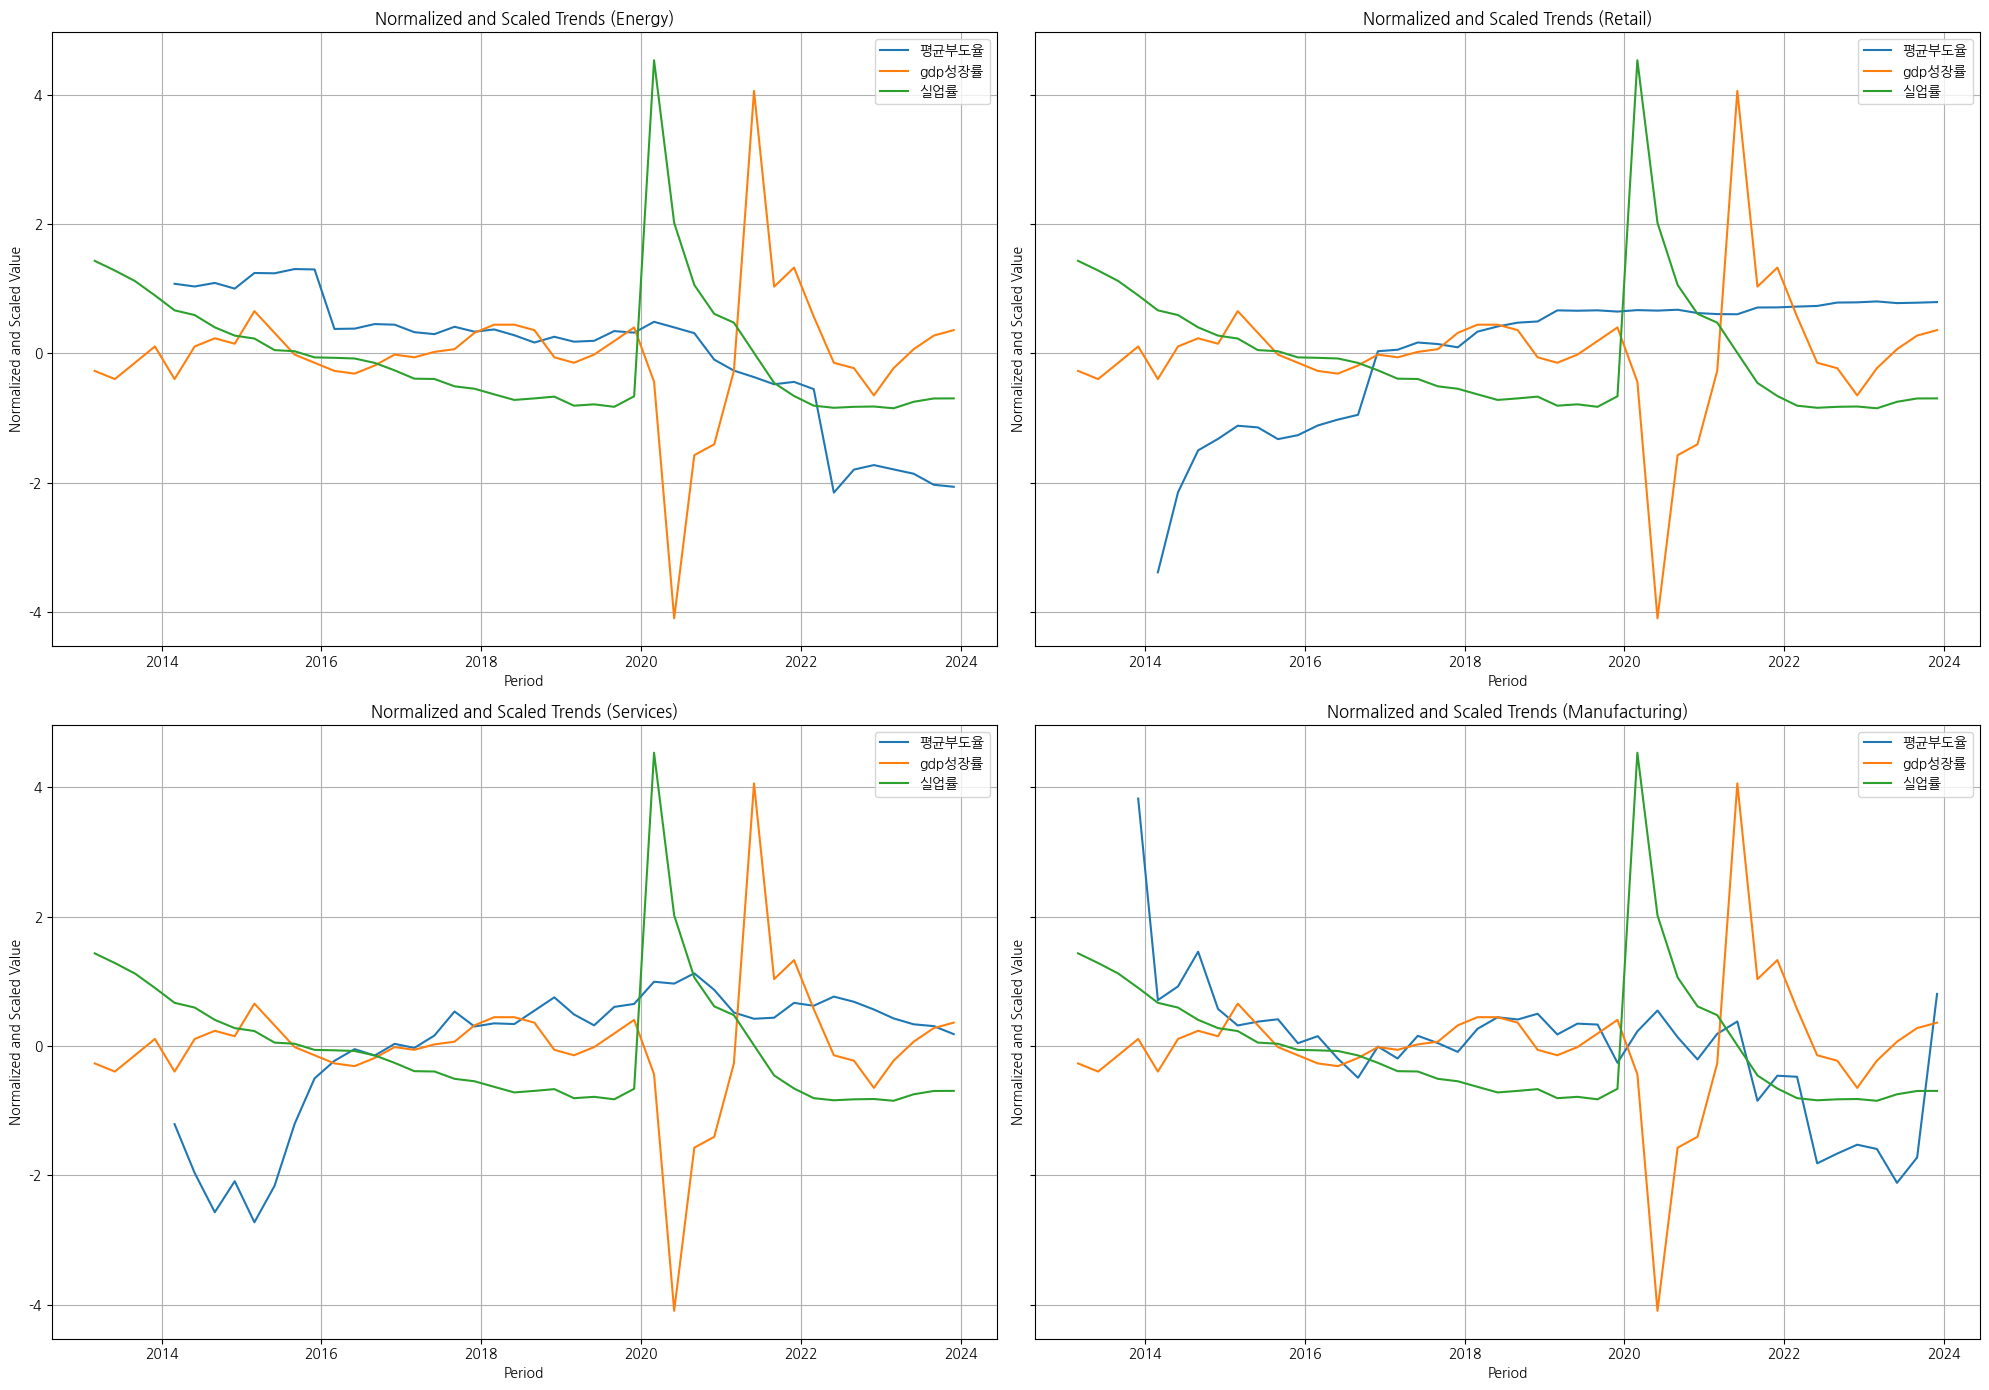

In [66]:
# Function to calculate default probabilities using the Merton model
def calculate_default_probability(V, D, r, sigma, T):
    if np.isnan(V) or np.isnan(D) or V <= 0 or D <= 0:
        return np.nan
    d1 = (np.log(V / D) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return 1 - stats.norm.cdf(d2)

# Function to calculate default probabilities for a given dataset using the Merton model
def calculate_default_probabilities(data):
    for i in range(1, 5):
        data[f'시가총액{i}'].replace(0, np.nan, inplace=True)
        data[f'부채{i}'].replace(0, np.nan, inplace=True)

    volatilities = [np.std(np.diff(np.log(data[f'시가총액{i}'].dropna()))) * np.sqrt(252) for i in range(1, 5)]

    for i in range(1, 5):
        sigma = volatilities[i-1]
        data[f'부도율{i}'] = data.apply(lambda row: calculate_default_probability(row[f'시가총액{i}'], row[f'부채{i}'], r, sigma, T), axis=1)

    return data

# Set parameters for the Merton model
r = 0.03  # Risk-free rate
T = 1     # Time to maturity in years

# Load all provided Excel files
file_paths = {
    "energy": '/content/미국_에너지.xlsx',
    "retail": '/content/미국_소매.xlsx',
    "services": '/content/미국_서비스.xlsx',
    "manufacturing": '/content/미국_제조.xlsx'
}

# Load and process data for each sector
data_energy = calculate_default_probabilities(pd.read_excel(file_paths['energy']))
data_retail = calculate_default_probabilities(pd.read_excel(file_paths['retail']))
data_services = calculate_default_probabilities(pd.read_excel(file_paths['services']))
data_manufacturing = calculate_default_probabilities(pd.read_excel(file_paths['manufacturing']))

# Calculate the mean default rate
data_energy['평균부도율'] = data_energy[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_retail['평균부도율'] = data_retail[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_services['평균부도율'] = data_services[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_manufacturing['평균부도율'] = data_manufacturing[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)


# Function to normalize and plot data
def normalize_and_plot(data, title, ax):
    plot_columns = ['평균부도율', 'gdp성장률', '실업률']
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data[plot_columns])
    normalized_df = pd.DataFrame(normalized_data, columns=plot_columns)
    normalized_df['기간'] = pd.to_datetime(data['기간'])

    for column in plot_columns:
        ax.plot(normalized_df['기간'], normalized_df[column], label=column)
    ax.set_title(title)
    ax.set_xlabel('Period')
    ax.set_ylabel('Normalized and Scaled Value')
    ax.legend()
    ax.grid(True)

# Plot the data for each sector
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14), sharey=True)

normalize_and_plot(data_energy, 'Normalized and Scaled Trends (Energy)', axes[0, 0])
normalize_and_plot(data_retail, 'Normalized and Scaled Trends (Retail)', axes[0, 1])
normalize_and_plot(data_services, 'Normalized and Scaled Trends (Services)', axes[1, 0])
normalize_and_plot(data_manufacturing, 'Normalized and Scaled Trends (Manufacturing)', axes[1, 1])

plt.tight_layout()
plt.show()


In [67]:
print(data_energy[['평균부도율', 'gdp성장률', '실업률']].corr())
print(data_retail[['평균부도율', 'gdp성장률', '실업률']].corr())
print(data_services[['평균부도율', 'gdp성장률', '실업률']].corr())
print(data_manufacturing[['평균부도율', 'gdp성장률', '실업률']].corr())

           평균부도율    gdp성장률       실업률
평균부도율   1.000000 -0.067176  0.374866
gdp성장률 -0.067176  1.000000 -0.368378
실업률     0.374866 -0.368378  1.000000
           평균부도율    gdp성장률       실업률
평균부도율   1.000000  0.006621 -0.200944
gdp성장률  0.006621  1.000000 -0.368378
실업률    -0.200944 -0.368378  1.000000
           평균부도율    gdp성장률       실업률
평균부도율   1.000000 -0.160126 -0.078363
gdp성장률 -0.160126  1.000000 -0.368378
실업률    -0.078363 -0.368378  1.000000
           평균부도율    gdp성장률       실업률
평균부도율   1.000000  0.013378  0.372679
gdp성장률  0.013378  1.000000 -0.368378
실업률     0.372679 -0.368378  1.000000


# 개별 데이터, 평균 그리기

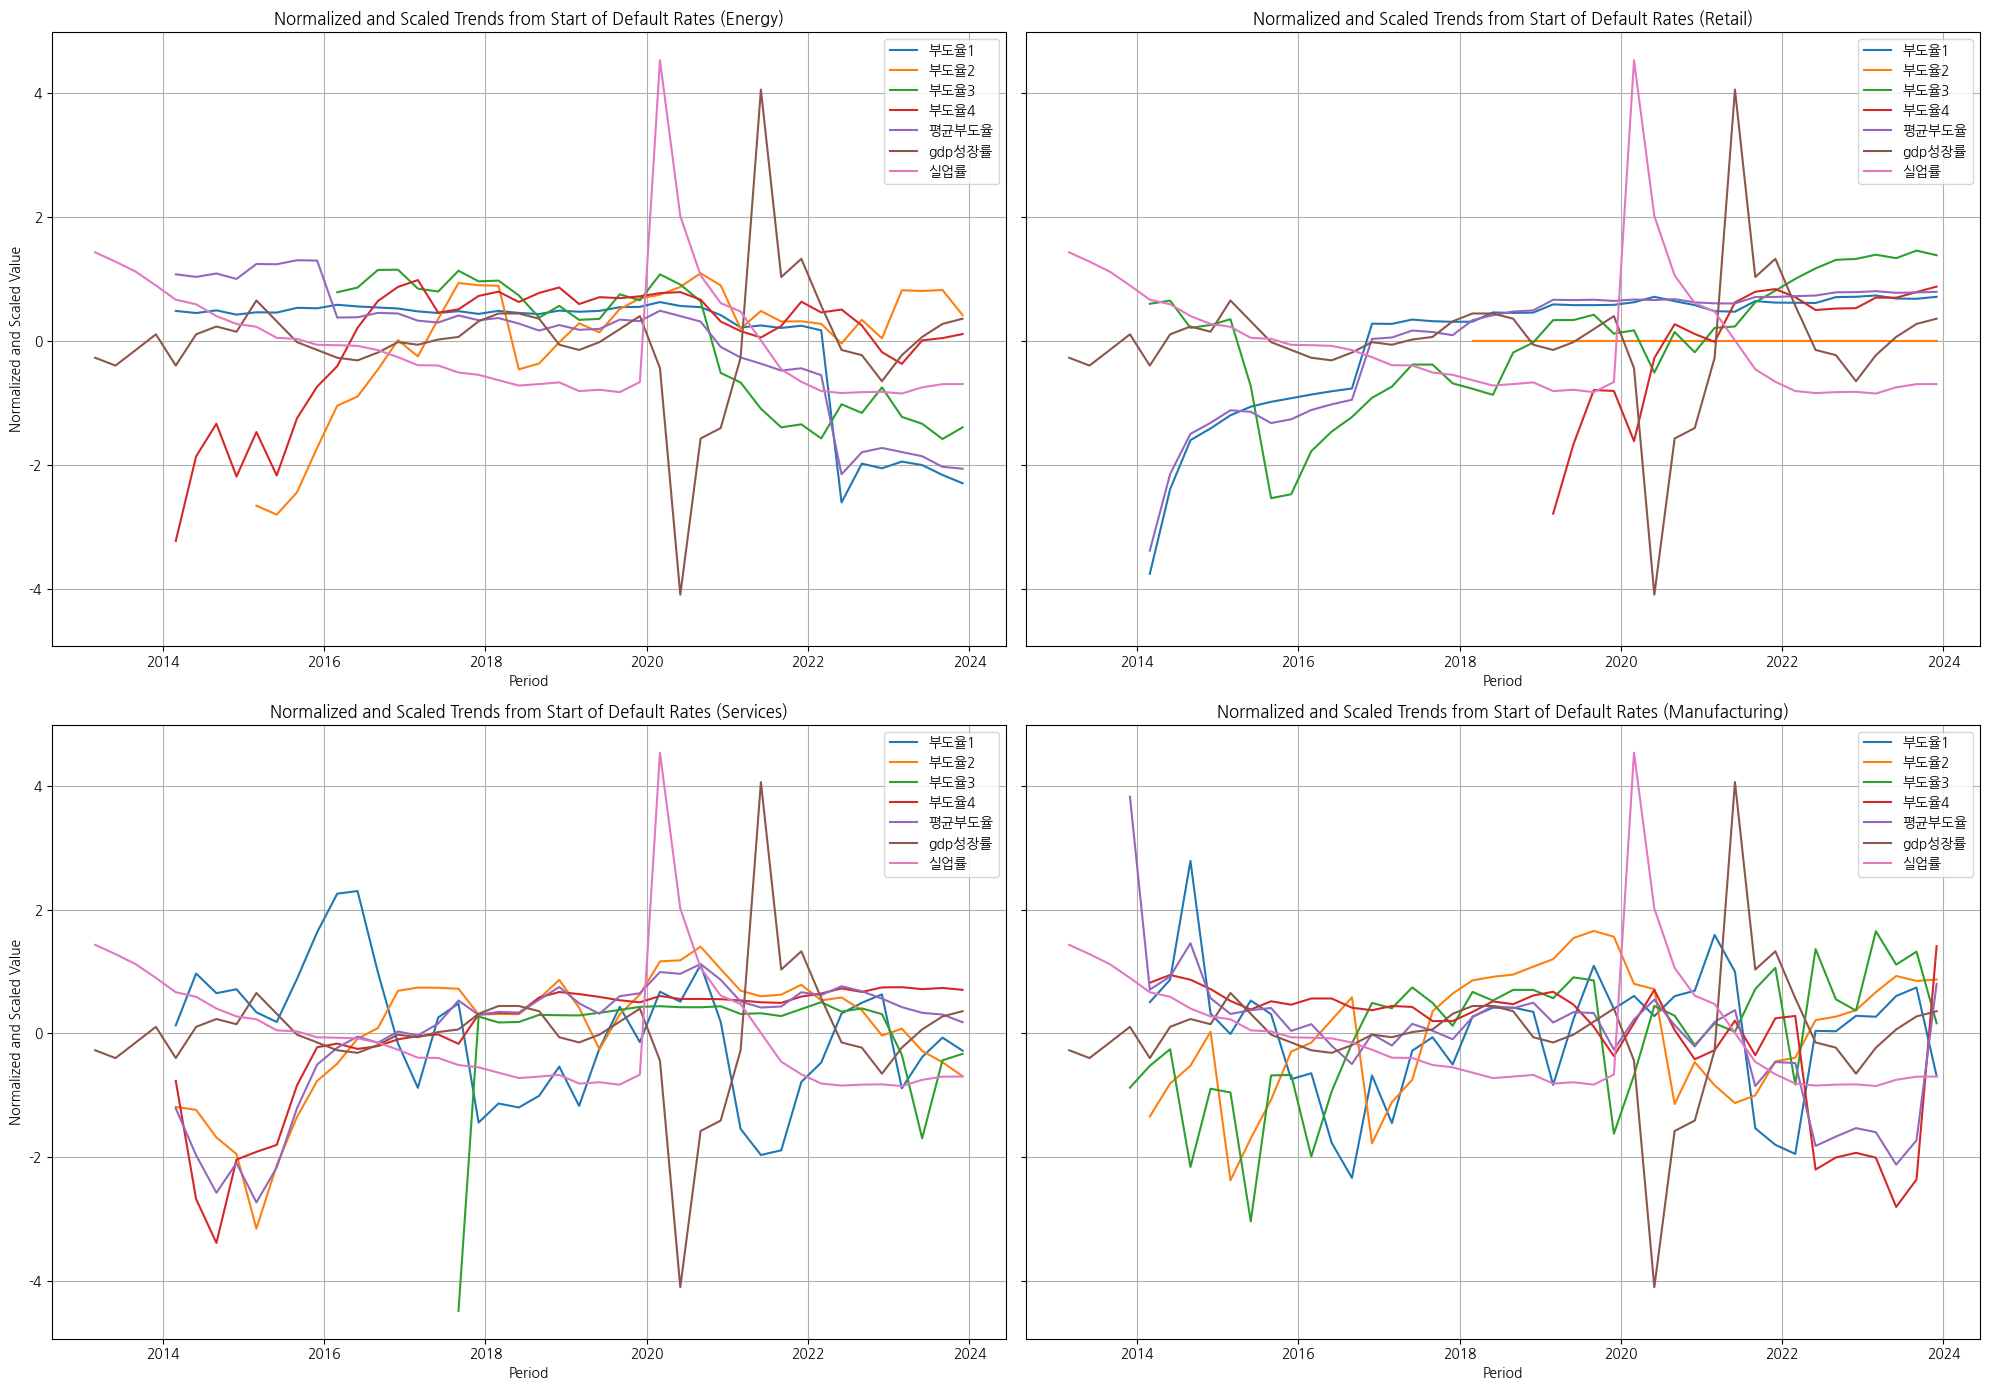

In [60]:
# Function to calculate default probabilities using the Merton model
def calculate_default_probability(V, D, r, sigma, T):
    if np.isnan(V) or np.isnan(D) or V <= 0 or D <= 0:
        return np.nan
    d1 = (np.log(V / D) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return 1 - stats.norm.cdf(d2)

# Function to calculate default probabilities for a given dataset using the Merton model
def calculate_default_probabilities(data):
    # Replace 0 or negative values with NaN to avoid division by zero or invalid log operations
    for i in range(1, 5):
        data[f'시가총액{i}'].replace(0, np.nan, inplace=True)
        data[f'부채{i}'].replace(0, np.nan, inplace=True)

    # Calculate volatility (σ) as the standard deviation of the percentage changes in market cap
    volatilities = [np.std(np.diff(np.log(data[f'시가총액{i}'].dropna()))) * np.sqrt(252) for i in range(1, 5)]

    # Calculate default probabilities for each company using the Merton model
    for i in range(1, 5):
        sigma = volatilities[i-1]
        data[f'부도율{i}'] = data.apply(lambda row: calculate_default_probability(row[f'시가총액{i}'], row[f'부채{i}'], r, sigma, T), axis=1)

    return data

# Set the risk-free rate and time to maturity (assuming 1 year)
r = 0.03  # Example risk-free rate
T = 1  # Time to maturity in years

# Load all provided Excel files
file_paths = {
    "energy": '/content/미국_에너지.xlsx',
    "retail": '/content/미국_소매.xlsx',
    "services": '/content/미국_서비스.xlsx',
    "manufacturing": '/content/미국_제조.xlsx'
}

data_energy = pd.read_excel(file_paths['energy'])
data_retail = pd.read_excel(file_paths['retail'])
data_services = pd.read_excel(file_paths['services'])
data_manufacturing = pd.read_excel(file_paths['manufacturing'])

# Calculate default probabilities for all datasets using the Merton model
data_energy = calculate_default_probabilities(data_energy)
data_retail = calculate_default_probabilities(data_retail)
data_services = calculate_default_probabilities(data_services)
data_manufacturing = calculate_default_probabilities(data_manufacturing)

# Calculate the mean default rates
data_energy['평균부도율'] = data_energy[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_retail['평균부도율'] = data_retail[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_services['평균부도율'] = data_services[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)
data_manufacturing['평균부도율'] = data_manufacturing[[f'부도율{i}' for i in range(1, 5)]].mean(axis=1)

# Extract relevant columns for individual default probabilities plotting, including the mean default rates
plot_columns_individual = [f'부도율{i}' for i in range(1, 5)] + ['평균부도율', 'gdp성장률', '실업률']

# Normalize the data for all datasets
scaler = StandardScaler()
normalized_plot_data_energy_individual = scaler.fit_transform(data_energy[plot_columns_individual])
normalized_plot_data_retail_individual = scaler.fit_transform(data_retail[plot_columns_individual])
normalized_plot_data_services_individual = scaler.fit_transform(data_services[plot_columns_individual])
normalized_plot_data_manufacturing_individual = scaler.fit_transform(data_manufacturing[plot_columns_individual])

# Convert normalized data back to a DataFrame
normalized_plot_df_energy_individual = pd.DataFrame(normalized_plot_data_energy_individual, columns=plot_columns_individual)
normalized_plot_df_retail_individual = pd.DataFrame(normalized_plot_data_retail_individual, columns=plot_columns_individual)
normalized_plot_df_services_individual = pd.DataFrame(normalized_plot_data_services_individual, columns=plot_columns_individual)
normalized_plot_df_manufacturing_individual = pd.DataFrame(normalized_plot_data_manufacturing_individual, columns=plot_columns_individual)
normalized_plot_df_energy_individual['기간'] = data_energy['기간']
normalized_plot_df_retail_individual['기간'] = data_retail['기간']
normalized_plot_df_services_individual['기간'] = data_services['기간']
normalized_plot_df_manufacturing_individual['기간'] = data_manufacturing['기간']

# Convert '기간' to datetime for better x-axis labels for all datasets
normalized_plot_df_energy_individual['기간'] = pd.to_datetime(normalized_plot_df_energy_individual['기간'])
normalized_plot_df_retail_individual['기간'] = pd.to_datetime(normalized_plot_df_retail_individual['기간'])
normalized_plot_df_services_individual['기간'] = pd.to_datetime(normalized_plot_df_services_individual['기간'])
normalized_plot_df_manufacturing_individual['기간'] = pd.to_datetime(normalized_plot_df_manufacturing_individual['기간'])

# Plot the normalized and scaled data for all datasets
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14), sharey=True)

# Plot for energy
for column in plot_columns_individual:
    axes[0, 0].plot(normalized_plot_df_energy_individual['기간'], normalized_plot_df_energy_individual[column], label=column)
axes[0, 0].set_title('Normalized and Scaled Trends from Start of Default Rates (Energy)')
axes[0, 0].set_xlabel('Period')
axes[0, 0].set_ylabel('Normalized and Scaled Value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot for retail
for column in plot_columns_individual:
    axes[0, 1].plot(normalized_plot_df_retail_individual['기간'], normalized_plot_df_retail_individual[column], label=column)
axes[0, 1].set_title('Normalized and Scaled Trends from Start of Default Rates (Retail)')
axes[0, 1].set_xlabel('Period')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot for services
for column in plot_columns_individual:
    axes[1, 0].plot(normalized_plot_df_services_individual['기간'], normalized_plot_df_services_individual[column], label=column)
axes[1, 0].set_title('Normalized and Scaled Trends from Start of Default Rates (Services)')
axes[1, 0].set_xlabel('Period')
axes[1, 0].set_ylabel('Normalized and Scaled Value')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot for manufacturing
for column in plot_columns_individual:
    axes[1, 1].plot(normalized_plot_df_manufacturing_individual['기간'], normalized_plot_df_manufacturing_individual[column], label=column)
axes[1, 1].set_title('Normalized and Scaled Trends from Start of Default Rates (Manufacturing)')
axes[1, 1].set_xlabel('Period')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


# 구버전

        부도율1      부도율2      부도율3      부도율4    gdp성장률       실업률         기간
0        NaN       NaN       NaN       NaN  0.469072  0.423614 2013-03-01
1        NaN       NaN       NaN       NaN  0.453608  0.395783 2013-06-01
2        NaN       NaN       NaN       NaN  0.484536  0.365557 2013-09-01
3        NaN       NaN  0.460970       NaN  0.515464  0.324422 2013-12-01
4   0.554250  0.255977  0.536258  0.859674  0.453608  0.281459 2014-03-01
5   0.625200  0.388390  0.593446  0.889468  0.515464  0.267824 2014-06-01
6   1.000000  0.459412  0.187510  0.871344  0.530928  0.232529 2014-09-01
7   0.518348  0.596085  0.457327  0.835436  0.520619  0.208774 2014-12-01
8   0.453751  0.000000  0.444393  0.789889  0.582474  0.200388 2015-03-01
9   0.559423  0.167930  0.000000  0.757033  0.541237  0.167198 2015-06-01
10  0.516290  0.323294  0.503069  0.788675  0.500000  0.163899 2015-09-01
11  0.311410  0.516191  0.504781  0.775451  0.484536  0.146241 2015-12-01
12  0.330053  0.552221  0.223708  0.79

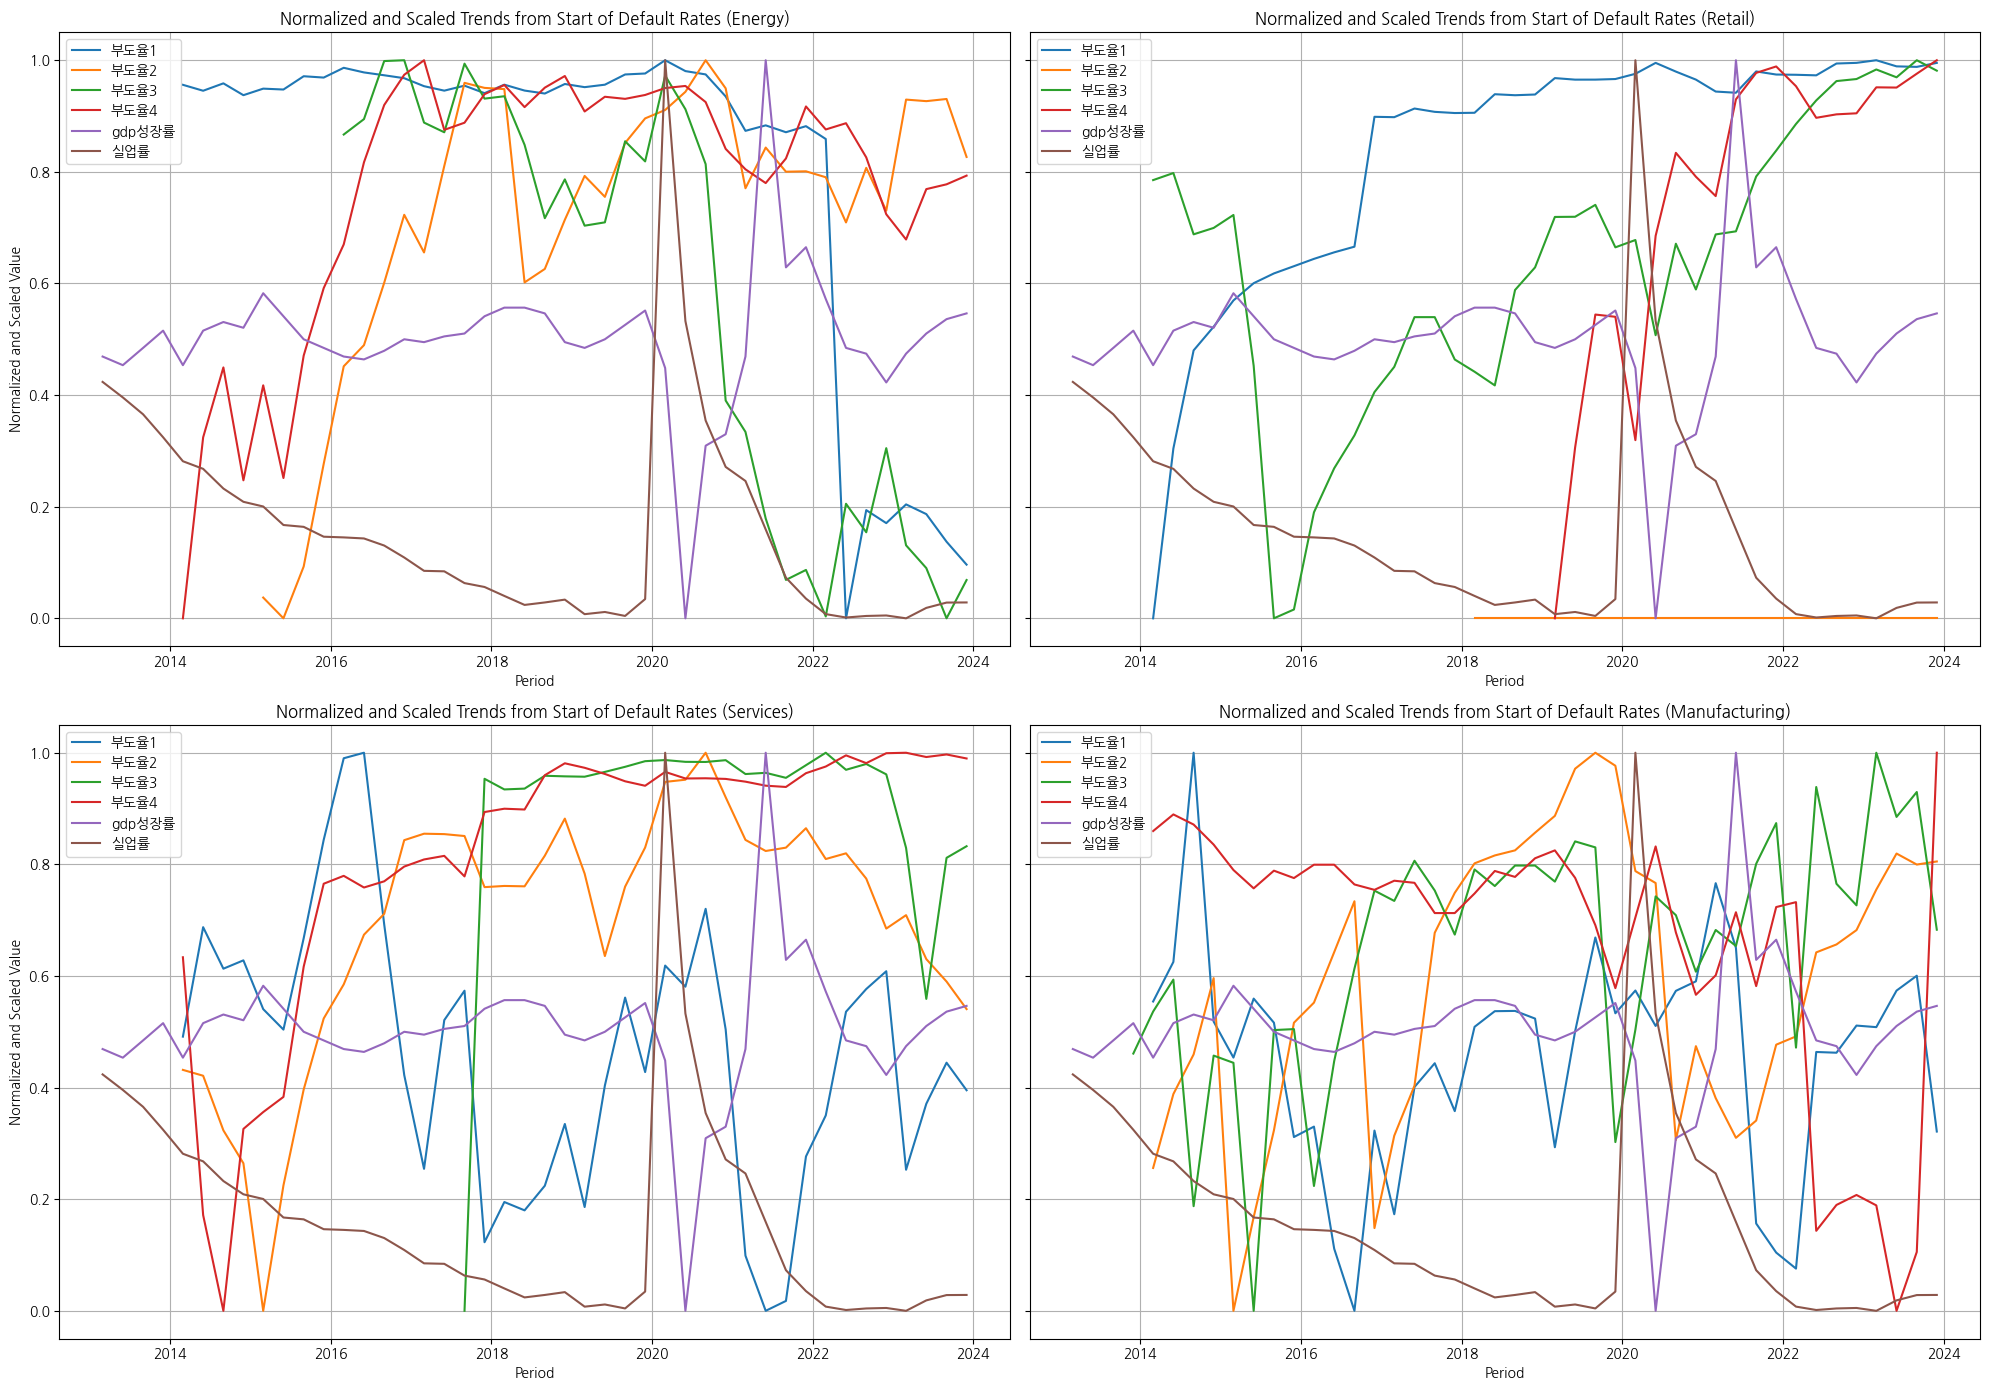

In [57]:
# Function to calculate default probabilities using the Merton model
def calculate_default_probability(V, D, r, sigma, T):
    if np.isnan(V) or np.isnan(D) or V <= 0 or D <= 0:
        return np.nan
    d1 = (np.log(V / D) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return 1 - stats.norm.cdf(d2)

# Function to calculate default probabilities for a given dataset using the Merton model
def calculate_default_probabilities(data):
    # Replace 0 or negative values with NaN to avoid division by zero or invalid log operations
    for i in range(1, 5):
        data[f'시가총액{i}'].replace(0, np.nan, inplace=True)
        data[f'부채{i}'].replace(0, np.nan, inplace=True)

    # Calculate volatility (σ) as the standard deviation of the percentage changes in market cap
    volatilities = [np.std(np.diff(np.log(data[f'시가총액{i}'].dropna()))) * np.sqrt(252) for i in range(1, 5)]

    # Calculate default probabilities for each company using the Merton model
    for i in range(1, 5):
        sigma = volatilities[i-1]
        data[f'부도율{i}'] = data.apply(lambda row: calculate_default_probability(row[f'시가총액{i}'], row[f'부채{i}'], r, sigma, T), axis=1)

    return data

# Set the risk-free rate and time to maturity (assuming 1 year)
r = 0.03  # Example risk-free rate
T = 1  # Time to maturity in years

# Load all provided Excel files
file_paths = {
    "energy": '/content/미국_에너지.xlsx',
    "retail": '/content/미국_소매.xlsx',
    "services": '/content/미국_서비스.xlsx',
    "manufacturing": '/content/미국_제조.xlsx'
}

data_energy = pd.read_excel(file_paths['energy'])
data_retail = pd.read_excel(file_paths['retail'])
data_services = pd.read_excel(file_paths['services'])
data_manufacturing = pd.read_excel(file_paths['manufacturing'])

# Calculate default probabilities for all datasets using the Merton model
data_energy = calculate_default_probabilities(data_energy)
data_retail = calculate_default_probabilities(data_retail)
data_services = calculate_default_probabilities(data_services)
data_manufacturing = calculate_default_probabilities(data_manufacturing)

# Extract relevant columns for individual default probabilities plotting
plot_columns_individual = [f'부도율{i}' for i in range(1, 5)] + ['gdp성장률', '실업률']

# Normalize the data for all datasets
scaler = MinMaxScaler()
normalized_plot_data_energy_individual = scaler.fit_transform(data_energy[plot_columns_individual])
normalized_plot_data_retail_individual = scaler.fit_transform(data_retail[plot_columns_individual])
normalized_plot_data_services_individual = scaler.fit_transform(data_services[plot_columns_individual])
normalized_plot_data_manufacturing_individual = scaler.fit_transform(data_manufacturing[plot_columns_individual])

# Convert normalized data back to a DataFrame
normalized_plot_df_energy_individual = pd.DataFrame(normalized_plot_data_energy_individual, columns=plot_columns_individual)
normalized_plot_df_retail_individual = pd.DataFrame(normalized_plot_data_retail_individual, columns=plot_columns_individual)
normalized_plot_df_services_individual = pd.DataFrame(normalized_plot_data_services_individual, columns=plot_columns_individual)
normalized_plot_df_manufacturing_individual = pd.DataFrame(normalized_plot_data_manufacturing_individual, columns=plot_columns_individual)
normalized_plot_df_energy_individual['기간'] = data_energy['기간']
normalized_plot_df_retail_individual['기간'] = data_retail['기간']
normalized_plot_df_services_individual['기간'] = data_services['기간']
normalized_plot_df_manufacturing_individual['기간'] = data_manufacturing['기간']


# # Set the starting point to 0 by subtracting the first value of each column
# for column in plot_columns_individual:
#     normalized_plot_df_energy_individual[column] = normalized_plot_df_energy_individual[column] - normalized_plot_df_energy_individual[column].iloc[0]
#     normalized_plot_df_retail_individual[column] = normalized_plot_df_retail_individual[column] - normalized_plot_df_retail_individual[column].iloc[0]
#     normalized_plot_df_services_individual[column] = normalized_plot_df_services_individual[column] - normalized_plot_df_services_individual[column].iloc[0]
#     normalized_plot_df_manufacturing_individual[column] = normalized_plot_df_manufacturing_individual[column] - normalized_plot_df_manufacturing_individual[column].iloc[0]

# Convert '기간' to datetime for better x-axis labels for all datasets
normalized_plot_df_energy_individual['기간'] = pd.to_datetime(normalized_plot_df_energy_individual['기간'])
normalized_plot_df_retail_individual['기간'] = pd.to_datetime(normalized_plot_df_retail_individual['기간'])
normalized_plot_df_services_individual['기간'] = pd.to_datetime(normalized_plot_df_services_individual['기간'])
normalized_plot_df_manufacturing_individual['기간'] = pd.to_datetime(normalized_plot_df_manufacturing_individual['기간'])

# Plot the normalized and scaled data for all datasets
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 14), sharey=True)


# Plot for energy
for column in plot_columns_individual:
    axes[0, 0].plot(normalized_plot_df_energy_individual['기간'], normalized_plot_df_energy_individual[column], label=column)
axes[0, 0].set_title('Normalized and Scaled Trends from Start of Default Rates (Energy)')
axes[0, 0].set_xlabel('Period')
axes[0, 0].set_ylabel('Normalized and Scaled Value')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot for retail
for column in plot_columns_individual:
    axes[0, 1].plot(normalized_plot_df_retail_individual['기간'], normalized_plot_df_retail_individual[column], label=column)
axes[0, 1].set_title('Normalized and Scaled Trends from Start of Default Rates (Retail)')
axes[0, 1].set_xlabel('Period')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot for services
for column in plot_columns_individual:
    axes[1, 0].plot(normalized_plot_df_services_individual['기간'], normalized_plot_df_services_individual[column], label=column)
axes[1, 0].set_title('Normalized and Scaled Trends from Start of Default Rates (Services)')
axes[1, 0].set_xlabel('Period')
axes[1, 0].set_ylabel('Normalized and Scaled Value')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot for manufacturing
for column in plot_columns_individual:
    axes[1, 1].plot(normalized_plot_df_manufacturing_individual['기간'], normalized_plot_df_manufacturing_individual[column], label=column)
axes[1, 1].set_title('Normalized and Scaled Trends from Start of Default Rates (Manufacturing)')
axes[1, 1].set_xlabel('Period')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# 구버전

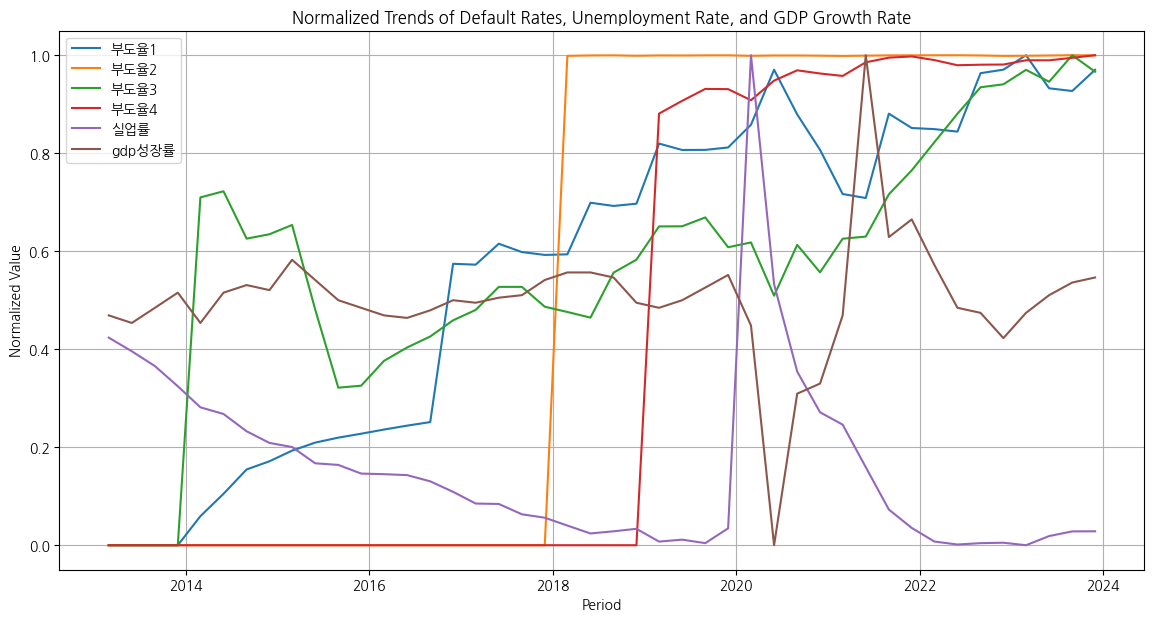

In [42]:
data = pd.read_excel("/content/미국_소매.xlsx")
r=0.041
T=data.shape[0]
scaler = MinMaxScaler()
# Replace 0 or negative values with NaN to avoid division by zero or invalid log operations
data['시가총액1'].replace(0, np.nan, inplace=True)
data['시가총액2'].replace(0, np.nan, inplace=True)
data['시가총액3'].replace(0, np.nan, inplace=True)
data['시가총액4'].replace(0, np.nan, inplace=True)
data['부채1'].replace(0, np.nan, inplace=True)
data['부채2'].replace(0, np.nan, inplace=True)
data['부채3'].replace(0, np.nan, inplace=True)
data['부채4'].replace(0, np.nan, inplace=True)

# Calculate volatility (σ) as the standard deviation of the percentage changes in market cap
# This is a simple proxy and may not be accurate
sigma1 = np.std(np.diff(np.log(data['시가총액1'].dropna()))) # * np.sqrt(252)  # Annualized volatility
sigma2 = np.std(np.diff(np.log(data['시가총액2'].dropna()))) # * np.sqrt(252)
sigma3 = np.std(np.diff(np.log(data['시가총액3'].dropna()))) # * np.sqrt(252)
sigma4 = np.std(np.diff(np.log(data['시가총액4'].dropna()))) # * np.sqrt(252)

def calculate_default_probability(V, D, r, sigma, T):
    if np.isnan(V) or np.isnan(D) or V <= 0 or D <= 0:
        return np.nan
    d1 = (np.log(V / D) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return 1 - stats.norm.cdf(d2)

# Calculate default probabilities for each company
data['부도율1'] = data.apply(lambda row: calculate_default_probability(row['시가총액1'], row['부채1'], r, sigma1, T), axis=1)
data['부도율2'] = data.apply(lambda row: calculate_default_probability(row['시가총액2'], row['부채2'], r, sigma2, T), axis=1)
data['부도율3'] = data.apply(lambda row: calculate_default_probability(row['시가총액3'], row['부채3'], r, sigma3, T), axis=1)
data['부도율4'] = data.apply(lambda row: calculate_default_probability(row['시가총액4'], row['부채4'], r, sigma4, T), axis=1)

# Extract necessary columns for plotting
plot_columns = ['부도율1', '부도율2', '부도율3', '부도율4', '실업률', 'gdp성장률']

# Handle any NaN values before normalization
data.fillna(0, inplace=True)

# Normalize the data
normalized_plot_data = scaler.fit_transform(data[plot_columns])

# Convert normalized data back to a DataFrame
normalized_plot_df = pd.DataFrame(normalized_plot_data, columns=plot_columns)

# Plot the normalized data
plt.figure(figsize=(14, 7))
for column in normalized_plot_df.columns:
    plt.plot(data['기간'], normalized_plot_df[column], label=column)

plt.title('Normalized Trends of Default Rates, Unemployment Rate, and GDP Growth Rate')
plt.xlabel('Period')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.show()

# 구버전

In [4]:
# 딕셔너리를 만들 때 필요한 리스트 변수를 만들고 반환하는 함수
def make_var_name_lst():
  var_name_lst = []
  # 각 기업 별로 나누기 위한 변수 만들기
  for i in range(1,5):
    tmp_lst = []
    date_name = '기간'
    profit_name = f'영업이익{i}'
    debt_name = f'부채{i}'
    market_name = f'시가총액{i}'
    tmp_lst.append(date_name)
    tmp_lst.append(profit_name)
    tmp_lst.append(debt_name)
    tmp_lst.append(market_name)
    var_name_lst.append(tmp_lst)
  return var_name_lst

In [5]:
# 각 기업 별 데이터프레임을 만들기 위한 딕셔너리를 만들고 반환하는 함수
def make_dict(country_df, company_lst):

  var_name_lst = make_var_name_lst()

  # 각 기업 별로 데이터프레임 만들기 위한 딕셔너리 만들기
  data_dict = {}
  for company, var in zip(company_lst, var_name_lst):
    data_dict[company] = country_df[var]
  return data_dict

In [6]:
# 각 기업 별 데이터프레임 만들기 위한 함수
def process_company_data(data_dict, company_key, var_name_lst_no_date, index):
  company = data_dict[company_key]
  company.index = company['기간']
  company = company.replace(0, np.nan)
  company = company.dropna()

  selected_vars = var_name_lst_no_date[index]
  company = company[selected_vars]
  company_profit_series = company[selected_vars[0]]
  company_debt_series = company[selected_vars[1]]
  company_market_series = company[selected_vars[2]]
  df_ = {
      '영업이익':company_profit_series,
      '부채':company_debt_series,
      '시가총액':company_market_series,
  }
  company_df = pd.DataFrame(df_, index=company.index)

  return company_df

In [7]:
# 해당 산업 내 기업들의 credit risk를 계산해 하나의 데이터프레임으로 만드는 함수
def cal_credit_risk(r, data_dict, company_lst, var_name_lst_no_date):
  series_container = []
  for i in range(len(company_lst)):
    company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
    company_i_profit_series = company_i['영업이익']
    company_i_debt_series = company_i['부채']
    company_i_market_series = company_i['시가총액']

    # recovery rate 계산
    recovery_rate_series_i = company_i_profit_series / company_i_debt_series
    recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
    # 부도확률 계산
    STD_V = company_i_market_series.std()
    R = r
    T = company_i_market_series.shape[0]
    tmp = []
    for V, K in zip(company_i_market_series, company_i_debt_series):
      d1 = ((np.log(V)-np.log(K)) + (R + 0.5 * STD_V**2) * T) / (STD_V * np.sqrt(T))
      d2 = d1 - STD_V * np.sqrt(T)
      # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
      def_prob = norm.logcdf(d2)
      tmp.append(def_prob)
    company_i_default_rate_series = pd.Series(tmp, index=company_i.index)
    company_i_default_rate_series = (company_i_default_rate_series/company_i_default_rate_series.iloc[0])
    company_i_default_rate_series = company_i_default_rate_series.clip(upper=1, lower=0)
    # EAD 계산
    company_i_ead_series = company_i_debt_series / company_i_debt_series.iloc[0]
    # credit risk 계산
    company_i_cr = company_i_default_rate_series * recovery_rate_series_i * company_i_ead_series
    # 데이터프레임 생성을 위한 리스트에 cr 시리즈를 붙인다.
    series_container.append(company_i_cr)

  # 데이터프레임 생성
  df = pd.DataFrame({'company1':series_container[0],'company2':series_container[1],'company3':series_container[2],'company4':series_container[3]})
  # 데이터프레임 반환
  return df

In [8]:
# 기본 변수들
manu_india = pd.read_excel("/content/미국_소매.xlsx") # make_dict의 매개변수로 쓰일 변수. 바꿔줘야 한다.
gdp_india = manu_india['gdp성장률']
gdp_india.index = manu_india['기간']
company_lst = ['company1', 'company2', 'company3', 'company4']
var_name_lst_no_date = [
    ['영업이익1', '부채1', '시가총액1'],
    ['영업이익2', '부채2', '시가총액2'],
    ['영업이익3', '부채3', '시가총액3'],
    ['영업이익4', '부채4', '시가총액4']
]
# gdp_india
manu_india

,기간,영업이익1,부채1,시가총액1,영업이익2,부채2,시가총액2,영업이익3,부채3,시가총액3,영업이익4,부채4,시가총액4,실업률,gdp성장률
0,2013-03-01,-0.984007,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,1812.461490,0.000000,0.000000,58.708146,7.682498,1.6
1,2013-06-01,-8.714422,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,1562.744574,0.000000,0.000000,68.428038,7.412812,1.3
2,2013-09-01,-1.889657,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,2215.230710,0.000000,0.000000,68.428038,7.119918,1.9
3,2013-12-01,-5.554220,0.000000,7497.696799,0.000000,0.000000,0.000000,0.000000,0.000000,1107.615355,0.000000,0.000000,68.428038,6.721312,2.5
4,2014-03-01,-5.748278,7.256745,7497.696799,0.000000,0.000000,0.000000,-2.924046,231.486445,1308.999965,0.000000,0.000000,88.256617,6.304996,1.3
5,2014-06-01,-11.016639,17.403856,7497.696799,0.000000,0.000000,0.000000,-11.364695,282.256362,1445.941500,0.000000,0.000000,68.428038,6.172873,2.5
6,2014-09-01,-28.697663,34.165786,7497.696799,0.000000,0.000000,0.000000,6.581411,225.986545,2416.615320,0.000000,0.000000,39.268363,5.830863,2.8
7,2014-12-01,-5.343051,41.417642,7497.696799,0.000000,0.000000,0.000000,-18.951297,251.494538,2517.307625,0.000000,0.000000,48.988255,5.600676,2.6
8,2015-03-01,-6.058581,52.256926,7497.696799,0.000000,0.000000,0.000000,3.754598,208.394199,1812.461490,0.000000,0.000000,48.988255,5.519415,3.8
9,2015-06-01,-5.975879,61.640299,7497.696799,0.000000,0.000000,0.000000,-10.743274,296.516720,9042.168989,0.000000,0.000000,68.428038,5.197796,3.0


In [9]:
R = 0.041
data_dict = make_dict(manu_india, company_lst)
cr_df = cal_credit_risk(R, data_dict, company_lst, var_name_lst_no_date)
# cr_df.shape
# cr_df.plot()
# 각자의 시작 시점이 기준.
cr_df['gdp'] = gdp_india
cr_df

,company1,company2,company3,company4,gdp
기간,,,,,
2014-03-01,0.000000,NaN,0.000000,NaN,1.3
2014-06-01,0.000000,NaN,0.000000,NaN,2.5
2014-09-01,0.000000,NaN,0.028431,NaN,2.8
2014-12-01,0.000000,NaN,0.000000,NaN,2.6
2015-03-01,0.000000,NaN,0.016220,NaN,3.8
2015-06-01,0.000000,NaN,0.000000,NaN,3.0
2015-09-01,0.000000,NaN,0.012617,NaN,2.2
2015-12-01,10.107678,NaN,0.000000,NaN,1.9
2016-03-01,0.000000,NaN,0.000000,NaN,1.6


In [10]:
cr_df_company = cr_df[company_lst]
cr_df_company.describe()

,company1,company2,company3,company4
count,40.000000,24.000000,40.000000,20.000000
mean,0.414457,0.008419,0.046502,29.099969
std,1.875365,0.023355,0.173543,107.476528
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.001850,0.000000,1.690615
max,10.107678,0.083626,1.049661,482.009026


In [11]:
company_i = data_dict['company1']
company_i

,기간,영업이익1,부채1,시가총액1
기간,,,,
2013-03-01,2013-03-01,-0.984007,0.000000,7497.696799
2013-06-01,2013-06-01,-8.714422,0.000000,7497.696799
2013-09-01,2013-09-01,-1.889657,0.000000,7497.696799
2013-12-01,2013-12-01,-5.554220,0.000000,7497.696799
2014-03-01,2014-03-01,-5.748278,7.256745,7497.696799
2014-06-01,2014-06-01,-11.016639,17.403856,7497.696799
2014-09-01,2014-09-01,-28.697663,34.165786,7497.696799
2014-12-01,2014-12-01,-5.343051,41.417642,7497.696799
2015-03-01,2015-03-01,-6.058581,52.256926,7497.696799


In [12]:
cr_df.corr()

,company1,company2,company3,company4,gdp
company1,1.000000,-0.076781,-0.060737,-0.063729,-0.045407
company2,-0.076781,1.000000,-0.111867,-0.102216,-0.025982
company3,-0.060737,-0.111867,1.000000,-0.063729,0.177916
company4,-0.063729,-0.102216,-0.063729,1.000000,-0.323547
gdp,-0.045407,-0.025982,0.177916,-0.323547,1.000000


<Axes: >

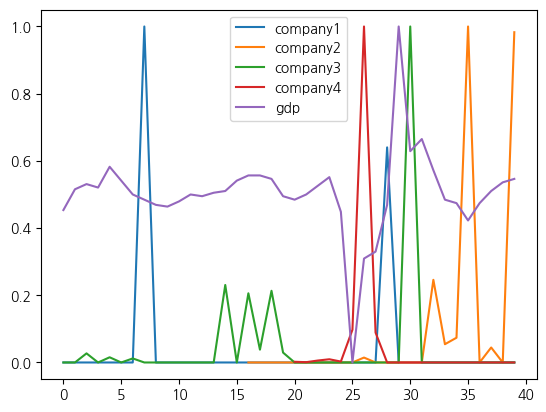

In [13]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(cr_df)
normalized_df = pd.DataFrame(normalized_data, columns=cr_df.columns)
normalized_df.plot()

In [14]:
normalized_df.mean()

company1    0.041004
company2    0.100674
company3    0.044302
company4    0.060372
gdp         0.504510
dtype: float64

In [15]:
print(normalized_df.corr().iloc[-1])

company1   -0.045407
company2   -0.025982
company3    0.177916
company4   -0.323547
gdp         1.000000
Name: gdp, dtype: float64


<Axes: >

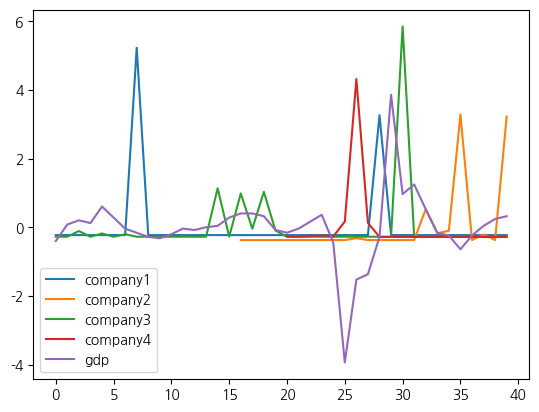

In [16]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(cr_df)
normalized_df = pd.DataFrame(normalized_data, columns=cr_df.columns)
normalized_df.plot()

In [17]:
normalized_df.corr().iloc[-1]

company1   -0.045407
company2   -0.025982
company3    0.177916
company4   -0.323547
gdp         1.000000
Name: gdp, dtype: float64

# 노트

In [33]:
################## 실험용 ###################
r = 0.041
series_container = {}
for i in range(len(company_lst)-3):
  company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
  company_i_profit_series = company_i['영업이익']
  company_i_debt_series = company_i['부채']
  company_i_market_series = company_i['시가총액']

  # recovery rate 계산
  recovery_rate_series_i = company_i_profit_series / company_i_debt_series
  recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
  # 부도확률 계산
  STD_V = company_i_market_series.std()
  R = r
  T = company_i_market_series.shape[0]
  tmp = []
  for V, K in zip(company_i_market_series, company_i_debt_series):
    d1 = ((np.log(V)-np.log(K)) + (R + 0.5 * STD_V**2) * T) / (STD_V * np.sqrt(T))
    d2 = d1 - STD_V * np.sqrt(T)
    # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
    def_prob = norm.logcdf(d2)
    tmp.append(def_prob)
  print(tmp) # 값은 계산이 됨
  company_i_default_rate_series = pd.Series(tmp, index=company_i.index)
  company_i_default_rate_series = (company_i_default_rate_series/company_i_default_rate_series.iloc[0])
  # print(company_i_default_rate_series)
  company_i_default_rate_series = company_i_default_rate_series.clip(upper=1, lower=0)
  # EAD 계산
  company_i_ead_series = company_i_debt_series / company_i_debt_series.iloc[0]
  # print(company_i_ead_series)
  # credit risk 계산
  company_i_cr = company_i_default_rate_series * recovery_rate_series_i * company_i_ead_series
  # 데이터프레임 생성을 위한 리스트에 cr 시리즈를 붙인다.
  series_container[company_lst[i]] = company_i_cr

# 데이터프레임 생성
# df = pd.DataFrame({'company1':series_container[0],'company2':series_container[1],'company3':series_container[2],'company4':series_container[3]})
# df

[-28118862.572477214, -28118863.009857435, -28118863.34712388, -28118863.44336497, -28118863.55959773, -28118863.642169435, -28118863.691355832, -28118863.729124844, -28118863.768566217, -28118863.804824255, -28118863.837055326, -28118865.027964164, -28118865.02203895, -28118865.170801826, -28118865.111216456, -28118865.090863556, -28118865.095137935, -28118865.473932438, -28118865.44944502, -28118865.46666648, -28118865.971593603, -28118865.91212694, -28118865.912910163, -28118865.93518214, -28118866.158632927, -28118866.91159487, -28118866.270932768, -28118865.913349368, -28118865.54162401, -28118865.510464266, -28118866.279728353, -28118866.124641497, -28118866.11331889, -28118866.088048052, -28118866.84725828, -28118866.913425382, -28118867.241207674, -28118866.60329829, -28118866.56475496, -28118866.910283033]


In [19]:
profit = []
debt = []
for i in range(len(company_lst)):
  company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
  company_i_profit_series = company_i['영업이익']
  company_i_debt_series = company_i['부채']
  # company_i_market_series = company_i['시가총액']
  profit.append(company_i_profit_series)
  debt.append(company_i_debt_series)

company_i_profit_series = pd.Series(profit)
company_i_debt_series = pd.Series(profit)
recovery_rate_series_i = company_i_profit_series / company_i_debt_series
# recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
profit
# recovery_rate_series_i

[기간
 2014-03-01      -5.748278
 2014-06-01     -11.016639
 2014-09-01     -28.697663
 2014-12-01      -5.343051
 2015-03-01      -6.058581
 2015-06-01      -5.975879
 2015-09-01     -36.644815
 2015-12-01     295.470109
 2016-03-01     -57.837899
 2016-06-01    -143.082139
 2016-09-01    -188.503708
 2016-12-01    -120.092014
 2017-03-01     -71.332209
 2017-06-01     -57.837899
 2017-09-01    -206.225201
 2017-12-01    -103.413058
 2018-03-01    -107.945519
 2018-06-01    -152.545091
 2018-09-01    -412.287849
 2018-12-01    -281.693878
 2019-03-01    -198.325851
 2019-06-01     -88.775448
 2019-09-01    -342.542735
 2019-12-01     -55.865540
 2020-03-01     -24.417519
 2020-06-01    -116.725804
 2020-09-01    -149.909484
 2020-12-01    -125.914846
 2021-03-01      46.955430
 2021-06-01    -205.275687
 2021-09-01    -779.425186
 2021-12-01     -10.569721
 2022-03-01    -112.999180
 2022-06-01    -106.890896
 2022-09-01   -2707.192419
 2022-12-01    -422.287890
 2023-03-01     -10.5697

In [20]:
company2 = data_dict['company3']
company2 = company2[var_name_lst_no_date[2]]
company2

,영업이익3,부채3,시가총액3
기간,,,
2013-03-01,0.000000,0.000000,1812.461490
2013-06-01,0.000000,0.000000,1562.744574
2013-09-01,0.000000,0.000000,2215.230710
2013-12-01,0.000000,0.000000,1107.615355
2014-03-01,-2.924046,231.486445,1308.999965
2014-06-01,-11.364695,282.256362,1445.941500
2014-09-01,6.581411,225.986545,2416.615320
2014-12-01,-18.951297,251.494538,2517.307625
2015-03-01,3.754598,208.394199,1812.461490


In [21]:
# company1
# company1.plot()
company2_profit_series = company2['영업이익3']
company2_debt_series = company2['부채3']
company2_market_series = company2['시가총액3']

In [22]:
# Recovery Rate 계산
# company1_profit_norm = (company1_profit_series / company1_profit_series[0])
recovery_rate_series = company2_profit_series / company2_debt_series
# recovery_rate의 값이 음수면 영업이익이 적자이므로 사실상 0. 1보다 크면 그냥 1임. 그러므로 LGD는 0이 됨.
recovery_rate_series = recovery_rate_series.clip(upper=1, lower=0)
recovery_rate_series

기간
2013-03-01         NaN
2013-06-01         NaN
2013-09-01         NaN
2013-12-01         NaN
2014-03-01    0.000000
2014-06-01    0.000000
2014-09-01    0.029123
2014-12-01    0.000000
2015-03-01    0.018017
2015-06-01    0.000000
2015-09-01    0.020594
2015-12-01    0.000000
2016-03-01    0.000000
2016-06-01    0.000000
2016-09-01    0.000000
2016-12-01    0.000000
2017-03-01    0.000000
2017-06-01    0.000000
2017-09-01    0.060785
2017-12-01    0.000000
2018-03-01    0.065556
2018-06-01    0.010497
2018-09-01    0.055271
2018-12-01    0.006927
2019-03-01    0.000000
2019-06-01    0.000000
2019-09-01    0.000000
2019-12-01    0.000000
2020-03-01    0.000000
2020-06-01    0.000000
2020-09-01    0.000000
2020-12-01    0.000000
2021-03-01    0.000000
2021-06-01    0.000000
2021-09-01    0.069798
2021-12-01    0.000000
2022-03-01    0.000000
2022-06-01    0.000000
2022-09-01    0.000000
2022-12-01    0.000000
2023-03-01    0.000000
2023-06-01    0.000000
2023-09-01    0.000000
2023-12-

In [23]:
# 개별 기업에 대해서 실험
# 부도확률 계산
STD_V = company2_market_series.std()
R = 0.041
T = company2_market_series.shape[0]
tmp = []
for V, K in zip(company2_market_series, company2_debt_series):
  d1 = (np.log(V) - np.log(K)) + ((R+(0.5*(STD_V**2)))*T) / (STD_V*np.sqrt(T))
  d2 = d1 - (STD_V*np.sqrt(T))
  # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
  def_prob = norm.logcdf(d2)
  tmp.append(def_prob)
#default_dict = {'부도율':tmp}
company2_default_rate_series = pd.Series(tmp, index=company2.index)
# mt_df_company1 = pd.DataFrame(def_dict, index=company1.index)
# 부도확률
company2_default_rate_series = 1-(company2_default_rate_series/company2_default_rate_series.iloc[0]) ############### 다른 점
company2_default_rate_series = company2_default_rate_series.clip(upper=1, lower=0)
company2_default_rate_series
# default_rate_df_company1.plot()
# company2_default_rate_series.plot()

기간
2013-03-01    NaN
2013-06-01    NaN
2013-09-01    NaN
2013-12-01    NaN
2014-03-01    1.0
2014-06-01    1.0
2014-09-01    1.0
2014-12-01    1.0
2015-03-01    1.0
2015-06-01    1.0
2015-09-01    1.0
2015-12-01    1.0
2016-03-01    1.0
2016-06-01    1.0
2016-09-01    1.0
2016-12-01    1.0
2017-03-01    1.0
2017-06-01    1.0
2017-09-01    1.0
2017-12-01    1.0
2018-03-01    1.0
2018-06-01    1.0
2018-09-01    1.0
2018-12-01    1.0
2019-03-01    1.0
2019-06-01    1.0
2019-09-01    1.0
2019-12-01    1.0
2020-03-01    1.0
2020-06-01    1.0
2020-09-01    1.0
2020-12-01    1.0
2021-03-01    1.0
2021-06-01    1.0
2021-09-01    1.0
2021-12-01    1.0
2022-03-01    1.0
2022-06-01    1.0
2022-09-01    1.0
2022-12-01    1.0
2023-03-01    1.0
2023-06-01    1.0
2023-09-01    1.0
2023-12-01    1.0
dtype: float64

In [24]:
# 개별 기업에 대해서 실험
# 부도확률 계산
STD_V = company2_market_series.std()
R = 0.041
T = company2_market_series.shape[0]
tmp = []
for V, K in zip(company2_market_series, company2_debt_series):
  d1 = (np.log(V) - np.log(K)) + ((R+(0.5*(STD_V**2)))*T) / (STD_V*np.sqrt(T))
  d2 = d1 - (STD_V*np.sqrt(T))
  # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
  def_prob = norm.logcdf(d2)
  tmp.append(def_prob)
#default_dict = {'부도율':tmp}
company2_default_rate_series = pd.Series(tmp, index=company2.index)
# mt_df_company1 = pd.DataFrame(def_dict, index=company1.index)
# 부도확률
company2_default_rate_series = (company2_default_rate_series/company2_default_rate_series.iloc[0])
company2_default_rate_series = company2_default_rate_series.clip(upper=1, lower=0)
company2_default_rate_series

기간
2013-03-01    NaN
2013-06-01    NaN
2013-09-01    NaN
2013-12-01    NaN
2014-03-01    0.0
2014-06-01    0.0
2014-09-01    0.0
2014-12-01    0.0
2015-03-01    0.0
2015-06-01    0.0
2015-09-01    0.0
2015-12-01    0.0
2016-03-01    0.0
2016-06-01    0.0
2016-09-01    0.0
2016-12-01    0.0
2017-03-01    0.0
2017-06-01    0.0
2017-09-01    0.0
2017-12-01    0.0
2018-03-01    0.0
2018-06-01    0.0
2018-09-01    0.0
2018-12-01    0.0
2019-03-01    0.0
2019-06-01    0.0
2019-09-01    0.0
2019-12-01    0.0
2020-03-01    0.0
2020-06-01    0.0
2020-09-01    0.0
2020-12-01    0.0
2021-03-01    0.0
2021-06-01    0.0
2021-09-01    0.0
2021-12-01    0.0
2022-03-01    0.0
2022-06-01    0.0
2022-09-01    0.0
2022-12-01    0.0
2023-03-01    0.0
2023-06-01    0.0
2023-09-01    0.0
2023-12-01    0.0
dtype: float64

In [25]:
# 해당 산업 내 기업들의 credit risk를 계산해 하나의 데이터프레임으로 만드는 함수. 값들은 전부 정규화된다.
def cal_credit_risk_norm(r, data_dict, company_lst, var_name_lst_no_date):
  series_container = []
  for i in range(len(company_lst)):
    company_i = process_company_data(data_dict, company_lst[i], var_name_lst_no_date, i)
    company_i_profit_series = company_i['영업이익']
    company_i_debt_series = company_i['부채']
    company_i_market_series = company_i['시가총액']

    # 정규화를 위한 scaler
    scaler = MinMaxScaler()

    # recovery rate 계산
    recovery_rate_series_i = company_i_profit_series / company_i_debt_series
    recovery_rate_series_i = recovery_rate_series_i.clip(upper=1, lower=0)
    # 부도확률 계산
    STD_V = company_i_market_series.std()
    R = r
    T = company_i_market_series.shape[0]
    tmp = []
    for V, K in zip(company_i_market_series, company_i_debt_series):
      d1 = (np.log(V/K) + (R + 0.5 * STD_V**2) * T) / (STD_V * np.sqrt(T))
      d2 = d1 - STD_V * np.sqrt(T)
      # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
      def_prob = norm.logcdf(d2)
      tmp.append(def_prob)
    company_i_default_rate_series = pd.Series(tmp, index=company_i.index)
    company_i_default_rate_series = (company_i_default_rate_series/company_i_default_rate_series.iloc[0])
    company_i_default_rate_series = company_i_default_rate_series.clip(upper=1, lower=0)
    # EAD 계산
    company_i_ead_series = company_i_debt_series / company_i_debt_series.iloc[0]
    # credit risk 계산
    company_i_cr = company_i_default_rate_series * recovery_rate_series_i * company_i_ead_series
    # 데이터프레임 생성을 위한 리스트에 cr 시리즈를 붙인다.
    series_container.append(company_i_cr)

  # 데이터프레임 생성
  df = pd.DataFrame({'company1':series_container[0],'company2':series_container[1],'company3':series_container[2],'company4':series_container[3]})
  # 데이터프레임 반환
  return df

In [26]:
# 개별 기업에 대해서 실험
# 부도확률 계산
STD_V = company2_market_series.std()
R = 0.041
T = company2_market_series.shape[0]
tmp = []
for V, K in zip(company2_market_series, company2_debt_series):
  d1 = (np.log(V) - np.log(K)) + ((R+(0.5*(STD_V**2)))*T) / (STD_V*np.sqrt(T))
  d2 = d1 - (STD_V*np.sqrt(T))
  # def_prob = 1-norm.logcdf(d2) # 1에서 빼나 안 빼나 값이 똑같이 나온다. 왜지?
  def_prob = norm.logcdf(d2)
  tmp.append(def_prob)
#default_dict = {'부도율':tmp}
company2_default_rate_series = pd.Series(tmp, index=company2.index)
# mt_df_company1 = pd.DataFrame(def_dict, index=company1.index)
# 부도확률
company2_default_rate_series = (company2_default_rate_series/company2_default_rate_series.iloc[0])
company2_default_rate_series = company2_default_rate_series.clip(upper=1, lower=0)
company2_default_rate_series

기간
2013-03-01    NaN
2013-06-01    NaN
2013-09-01    NaN
2013-12-01    NaN
2014-03-01    0.0
2014-06-01    0.0
2014-09-01    0.0
2014-12-01    0.0
2015-03-01    0.0
2015-06-01    0.0
2015-09-01    0.0
2015-12-01    0.0
2016-03-01    0.0
2016-06-01    0.0
2016-09-01    0.0
2016-12-01    0.0
2017-03-01    0.0
2017-06-01    0.0
2017-09-01    0.0
2017-12-01    0.0
2018-03-01    0.0
2018-06-01    0.0
2018-09-01    0.0
2018-12-01    0.0
2019-03-01    0.0
2019-06-01    0.0
2019-09-01    0.0
2019-12-01    0.0
2020-03-01    0.0
2020-06-01    0.0
2020-09-01    0.0
2020-12-01    0.0
2021-03-01    0.0
2021-06-01    0.0
2021-09-01    0.0
2021-12-01    0.0
2022-03-01    0.0
2022-06-01    0.0
2022-09-01    0.0
2022-12-01    0.0
2023-03-01    0.0
2023-06-01    0.0
2023-09-01    0.0
2023-12-01    0.0
dtype: float64

In [27]:
company1 = data_dict['company1'][['영업이익1', '부채1', '시가총액1']]
selected_vars = var_name_lst_no_date[0]
company1[selected_vars[0]]

기간
2013-03-01      -0.984007
2013-06-01      -8.714422
2013-09-01      -1.889657
2013-12-01      -5.554220
2014-03-01      -5.748278
2014-06-01     -11.016639
2014-09-01     -28.697663
2014-12-01      -5.343051
2015-03-01      -6.058581
2015-06-01      -5.975879
2015-09-01     -36.644815
2015-12-01     295.470109
2016-03-01     -57.837899
2016-06-01    -143.082139
2016-09-01    -188.503708
2016-12-01    -120.092014
2017-03-01     -71.332209
2017-06-01     -57.837899
2017-09-01    -206.225201
2017-12-01    -103.413058
2018-03-01    -107.945519
2018-06-01    -152.545091
2018-09-01    -412.287849
2018-12-01    -281.693878
2019-03-01    -198.325851
2019-06-01     -88.775448
2019-09-01    -342.542735
2019-12-01     -55.865540
2020-03-01     -24.417519
2020-06-01    -116.725804
2020-09-01    -149.909484
2020-12-01    -125.914846
2021-03-01      46.955430
2021-06-01    -205.275687
2021-09-01    -779.425186
2021-12-01     -10.569721
2022-03-01    -112.999180
2022-06-01    -106.890896
2022-09-0

In [28]:
company1 = process_company_data(data_dict, company_lst[0], var_name_lst_no_date, 0)
company1

,영업이익,부채,시가총액
기간,,,
2014-03-01,-5.748278,7.256745,7497.696799
2014-06-01,-11.016639,17.403856,7497.696799
2014-09-01,-28.697663,34.165786,7497.696799
2014-12-01,-5.343051,41.417642,7497.696799
2015-03-01,-6.058581,52.256926,7497.696799
2015-06-01,-5.975879,61.640299,7497.696799
2015-09-01,-36.644815,68.012307,7497.696799
2015-12-01,295.470109,73.348839,7497.696799
2016-03-01,-57.837899,79.369125,7497.696799


In [29]:
# Sample DataFrame
data = {'A': [1, 2, 3, 4, 5], 'B': [10, 20, 30, 40, 50]}
df = pd.DataFrame(data)

# Normalization
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df)

normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
print(normalized_df)

      A     B
0  0.00  0.00
1  0.25  0.25
2  0.50  0.50
3  0.75  0.75
4  1.00  1.00


In [30]:
# Sample DataFrame
data = {'A': [1, 2, 3, 4, 5], 'B': [10, 20, 30, 40, 50]}
df = pd.DataFrame(data)

# Standardization
scaler = StandardScaler()
standardized_data = scaler.fit_transform(df)

standardized_df = pd.DataFrame(standardized_data, columns=df.columns)
print(standardized_df)

          A         B
0 -1.414214 -1.414214
1 -0.707107 -0.707107
2  0.000000  0.000000
3  0.707107  0.707107
4  1.414214  1.414214
